# Model Creation and Tuning

## Index

- [Data Preprocessing](#Data-Preprocessing)
- [Baseline Linear Model](#Baseline-Linear-Model)
- [Baseline Random Forest](#Baseline-Random-Forest)
- [Baseline XGB model](#Baseline-XGB-model)
- [A Simple Neural-Net](#A-Simple-Neural-Net)
- [Hyperparamerter tuning](#Hyperparamerter-tuning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import sklearn
import os 
import sys
import json

In [4]:
import seaborn as sns

In [5]:
import pickle

In [6]:
from sklearn.metrics import *

In [7]:
from sklearn.model_selection import *
from sklearn.metrics import *

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

In [8]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [9]:
# import keras
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [10]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [11]:
from tensorflow.keras.optimizers import Adam

In [12]:
from sklearn.model_selection import RandomizedSearchCV

## Data Preprocessing

In [13]:
data = pd.read_csv('processed/training_df.csv')

In [14]:
data.drop(columns=['Unnamed: 0'], inplace = True)

In [15]:
data.columns

Index(['isAdult', 'startYear', 'runtimeMinutes', 'averageRating', 'numVotes',
       'cast_mean', 'cast_std', 'cast_max', 'crew_mean', 'crew_std',
       'crew_max', 'cast_exp', 'crew_exp', 'numRegions', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [16]:
label = 'averageRating'
numerical_cols = ['runtimeMinutes', 'numVotes','cast_mean', 
                  'cast_std', 'cast_max', 'crew_mean', 'crew_std',
                'crew_max', 'cast_exp', 'crew_exp', 'numRegions']
ordinal_cols = ['startYear']

In [17]:
def scaler(data, numerical_cols, ordinal_cols, save = False):
    if numerical_cols:
        ss  = StandardScaler()
        data.loc[:, numerical_cols] = ss.fit_transform(data[numerical_cols])
    if ordinal_cols:
        os = OrdinalEncoder()
        data.loc[:, ordinal_cols] = ss.fit_transform(data[ordinal_cols])
    if save:
        with open('models/standard_scaler', 'wb') as f:
            pickle.dump(ss, f)
        with open('models/ordinal_scaler', 'wb') as f:
            pickle.dump(os, f)
    return data

In [18]:
data_scaled = scaler(data, numerical_cols, ordinal_cols, save=True)

In [19]:
data_scaled

,isAdult,startYear,runtimeMinutes,averageRating,numVotes,cast_mean,cast_std,cast_max,crew_mean,crew_std,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,-1.319724,0.068700,4.5,-0.095872,-1.947168,-0.997854,-3.015751,-0.986950,1.005087,...,0,0,0,0,0,0,0,0,0,0
1,0,-1.319724,-0.166455,6.0,-0.072000,-0.208452,-0.997854,-1.450210,-0.472322,-0.953246,...,0,0,0,0,0,0,0,0,0,0
2,0,-1.319724,-0.009685,4.6,-0.095775,-1.160606,-0.997854,-1.737226,-1.630350,-0.408200,...,0,0,0,0,0,0,0,0,0,0
3,0,-1.319724,0.037346,4.5,-0.095581,-1.599425,-0.997854,-2.389535,-1.668844,-0.953246,...,0,0,0,0,0,0,0,0,0,0
4,0,-1.319724,0.303856,3.8,-0.095549,-0.976385,1.338778,-0.771809,-0.473268,1.763490,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323829,0,1.161934,0.005992,6.4,0.047136,-0.035898,-0.997854,0.193608,0.164157,-0.953246,...,0,0,0,0,0,0,0,0,0,0
323830,0,1.112301,0.013831,3.8,-0.095872,-1.897582,-0.997854,-2.406930,-1.755456,1.167940,...,0,0,0,0,0,0,0,0,1,0
323831,0,1.112301,-0.636766,9.3,-0.095775,3.616722,-0.997854,1.993980,3.566343,-0.953246,...,0,0,0,0,0,0,0,0,0,0
323832,0,1.112301,0.248986,8.3,-0.096130,1.261004,-0.997854,0.950286,1.006749,-0.953246,...,0,0,0,0,0,0,0,0,0,0


In [20]:
train_cols = ['isAdult', 'startYear', 'runtimeMinutes', 'numVotes',
       'cast_mean', 'cast_std', 'cast_max', 'crew_mean', 'crew_std',
       'crew_max', 'cast_exp', 'crew_exp', 'numRegions', 'Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
       'Western']

In [21]:
X = data_scaled[train_cols].values

In [22]:
y = data[label]

In [23]:
X.shape, y.shape

((323834, 41), (323834,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [25]:
print(f"Xtrain shape: {X_train.shape}")
print(f"Xtrain shape: {X_test.shape}")
print(f"Xtrain shape: {y_train.shape}")
print(f"Xtrain shape: {y_test.shape}")

Xtrain shape: (226683, 41)
Xtrain shape: (97151, 41)
Xtrain shape: (226683,)
Xtrain shape: (97151,)


## Baseline Linear Model


This Linear regression model provides a baseline for our other machine learning models

In [26]:
lr = LinearRegression(n_jobs=-1)

In [27]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [28]:

lr.score(X_train, y_train)

0.7430537794248169

In [29]:
lr.score(X_test, y_test)

0.7456695128983963

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]),
 <a list of 41 Text xticklabel objects>)

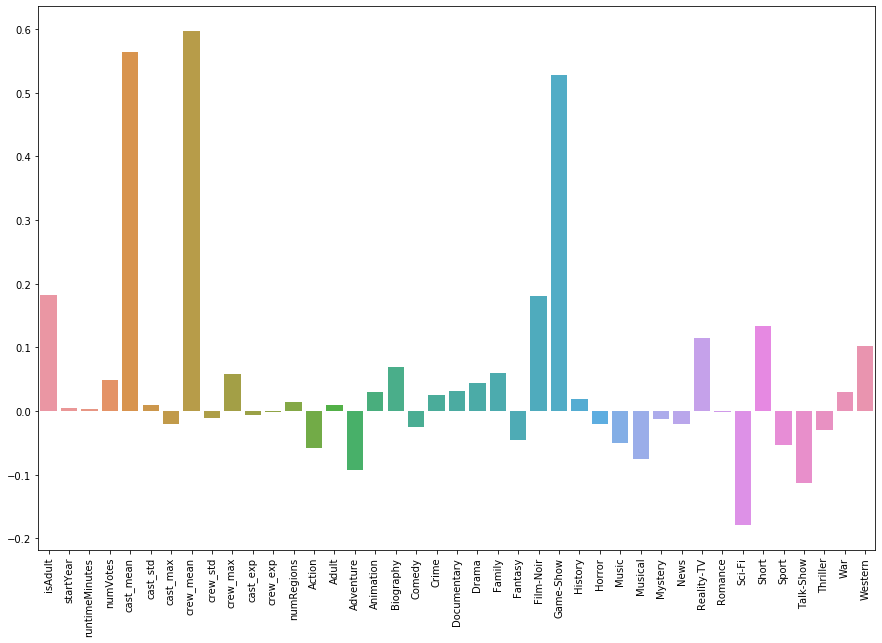

In [30]:
plt.figure(figsize = (15,10))
sns.barplot(x = train_cols, y = lr.coef_, )
plt.xticks(rotation=90)

The coefficient values provide an indication of which variables are contributing to the models decisions for the final predictions. We can see that the `crew_mean` and `cast_mean` features have a very positive relationship with the rating. Certain genres like `film-noir`, `animation`, `short` and `western` also have a strong positive relationship with the IMDB rating. Other genres like `sci-fi` and `adventure` show a negative relationship

## Baseline Random Forest

Out random forest model overfits on the data, tuning hyperparameters and adding some regularization can help mitigate this.

In [257]:
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [258]:
rf_model.score(X_train, y_train)

0.9759288538207402

In [259]:
rf_model.score(X_test, y_test)

0.8301784072179509

## Baseline XGB model


In [271]:
xgb = XGBRegressor(subsample=0.8, n_jobs=-1, )

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [272]:
xgb.score(X_train, y_train)

0.8528961559157758

In [273]:
xgb.score(X_test, y_test)

0.8325755483882249

## A Simple Neural Net

In [274]:
def create_model(input_size):
    model = keras.Sequential()
    model.add(layers.Input(shape = (input_size, )))
    model.add(layers.Dense(32, activation = 'relu'))

    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(64, activation = 'relu'))

    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(1))
    
    opt = Adam(lr=1e-4, decay=1e-3 / 200)
    model.compile(loss = 'mse', optimizer=opt)
    
    return model

In [275]:
model = create_model(X.shape[1])

/home/tanmay/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [276]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 32)                1344      
                                                                 
 dense_46 (Dense)            (None, 64)                2112      
                                                                 
 dense_47 (Dense)            (None, 128)               8320      
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 1)                 33        
                                                                 
Total params: 22,145
Trainable params: 22,145
Non-trai

In [277]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          batch_size = 512, workers = -1, epochs = 40, verbose = 1)

Epoch 1/40
443/443 [==============================] - 2s 3ms/step - loss: 13.0993 - val_loss: 2.2141
Epoch 2/40
443/443 [==============================] - 1s 3ms/step - loss: 2.5593 - val_loss: 1.0767
Epoch 3/40
443/443 [==============================] - 2s 5ms/step - loss: 1.3402 - val_loss: 0.7083
Epoch 4/40
443/443 [==============================] - 1s 3ms/step - loss: 0.8033 - val_loss: 0.5339
Epoch 5/40
443/443 [==============================] - 1s 3ms/step - loss: 0.5334 - val_loss: 0.4618
Epoch 6/40
443/443 [==============================] - 2s 5ms/step - loss: 0.4492 - val_loss: 0.4327
Epoch 7/40
443/443 [==============================] - 1s 3ms/step - loss: 0.4205 - val_loss: 0.4148
Epoch 8/40
443/443 [==============================] - 1s 3ms/step - loss: 0.4057 - val_loss: 0.4025
Epoch 9/40
443/443 [==============================] - 3s 7ms/step - loss: 0.3958 - val_loss: 0.3938
Epoch 10/40
443/443 [==============================] - 1s 3ms/step - loss: 0.3876 - val_loss: 0.386

In [278]:
y_train_pred = model.predict(X_train)

In [279]:
y_test_pred = model.predict(X_test)

In [280]:
r2_score(y_train_pred, y_train)

0.7838895944286715

In [281]:
r2_score(y_test_pred, y_test)

0.7830962966115287

## Hyperparamerter tuning

To get the best performance out of the mode, I used hyperopt to find an optimal set of hyperparameters for our XGBoost model

In [31]:
# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.quniform('learning_rate', 0.2, 0.4, 0.05),
    'max_depth':        hp.choice('max_depth',        np.arange(6, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(2, 6, 1, dtype=int)),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1, 0.1),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
     'n_jobs': -1
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [32]:
xgb_para

{'reg_params': {'learning_rate': <hyperopt.pyll.base.Apply at 0x7fa3b64c0210>,
  'max_depth': <hyperopt.pyll.base.Apply at 0x7fa3b646c050>,
  'min_child_weight': <hyperopt.pyll.base.Apply at 0x7fa3b646c450>,
  'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7fa3b646c710>,
  'subsample': <hyperopt.pyll.base.Apply at 0x7fa3b646c890>,
  'n_estimators': 100,
  'n_jobs': -1},
 'fit_params': {'eval_metric': 'rmse',
  'early_stopping_rounds': 10,
  'verbose': False},
 'loss_func': <function __main__.<lambda>(y, pred)>}

In [33]:
def objective(xgb_para):
#     print(xgb_para)
    reg=XGBRegressor( **xgb_para['reg_params'])
    
    evaluation = [(X_train, y_train), ( X_test, y_test)]
    
    reg.fit(X_train, y_train,
            eval_set=evaluation,
            eval_metric = xgb_para['fit_params']['eval_metric'],
            early_stopping_rounds=xgb_para['fit_params']['early_stopping_rounds'],
            verbose=False)
    

    pred = reg.predict(X_test)
#     r2 = r2_score(y_test, pred)
#     print ("SCORE:", r2)
    loss = xgb_para['loss_func'](y_test, pred)
    return {'loss': loss, 'status': STATUS_OK }

In [34]:
trials = Trials()

In [35]:
best_hyperparams = fmin(fn = objective,
                        space = xgb_para,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [41:26<00:00, 24.86s/trial, best loss: 0.5471998946757579]


In [36]:
best_hyperparams

{'colsample_bytree': 1.0,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 3,
 'subsample': 0.8494493452149325}

In [37]:
reg=XGBRegressor( **best_hyperparams)
    
evaluation = [(X_train, y_train), ( X_test, y_test)]

reg.fit(X_train, y_train,
        eval_set=evaluation,
        eval_metric = xgb_para['fit_params']['eval_metric'],
        early_stopping_rounds=xgb_para['fit_params']['early_stopping_rounds'],
        verbose=True)

[0]	validation_0-rmse:4.72111	validation_1-rmse:4.72132
[1]	validation_0-rmse:3.80197	validation_1-rmse:3.80210
[2]	validation_0-rmse:3.07164	validation_1-rmse:3.07187
[3]	validation_0-rmse:2.49241	validation_1-rmse:2.49244
[4]	validation_0-rmse:2.03637	validation_1-rmse:2.03652
[5]	validation_0-rmse:1.67925	validation_1-rmse:1.67927
[6]	validation_0-rmse:1.40300	validation_1-rmse:1.40288
[7]	validation_0-rmse:1.19232	validation_1-rmse:1.19234
[8]	validation_0-rmse:1.03363	validation_1-rmse:1.03386
[9]	validation_0-rmse:0.91672	validation_1-rmse:0.91708
[10]	validation_0-rmse:0.83271	validation_1-rmse:0.83304
[11]	validation_0-rmse:0.77295	validation_1-rmse:0.77355
[12]	validation_0-rmse:0.73144	validation_1-rmse:0.73205
[13]	validation_0-rmse:0.70315	validation_1-rmse:0.70386
[14]	validation_0-rmse:0.68275	validation_1-rmse:0.68356
[15]	validation_0-rmse:0.66939	validation_1-rmse:0.67045
[16]	validation_0-rmse:0.65958	validation_1-rmse:0.66079
[17]	validation_0-rmse:0.65292	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8494493452149325,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
reg.score(X_train, y_train)

0.8029051010614847

In [41]:
reg.score(X_test, y_test)

0.8017566426975278

In [218]:
imp = pd.DataFrame({"importances": reg.feature_importances_},index= train_cols).sort_values(by = 'importances', 
                                                                                                 ascending = False)

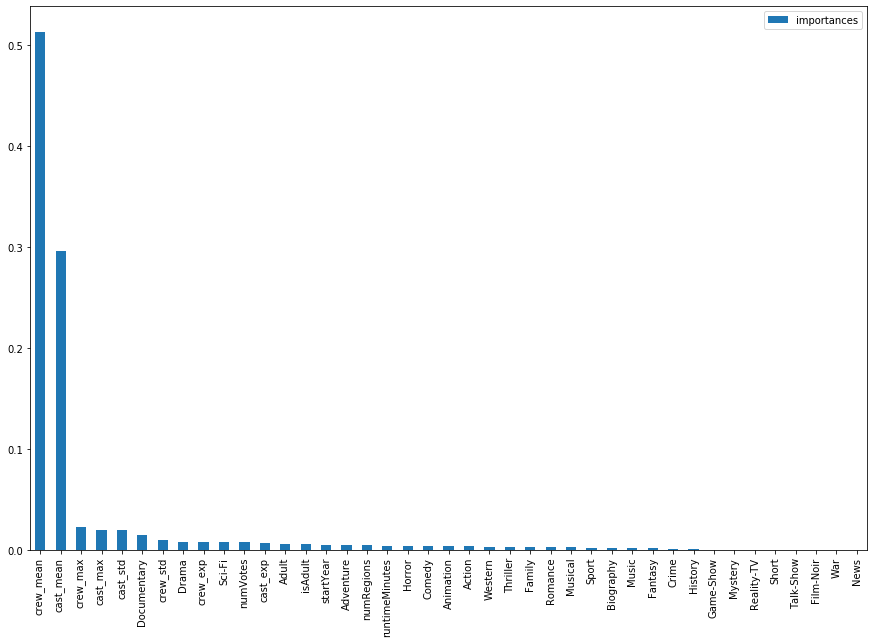

In [219]:
imp.plot.bar(figsize = (15, 10))

We can see the crew ratings and cast ratings dominate the predictions for the movies
It will be interesting to see how a model will perform without these features

In [236]:
train_cols_sub =  ['isAdult', 'startYear', 'runtimeMinutes', 'numVotes', 'cast_std', 'crew_std',
                   'cast_exp', 'crew_exp', 'numRegions', 'Action', 'Adult',
                   'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
                   'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
                   'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
                   'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
                   'Western']

In [237]:
X = data_scaled[train_cols_sub].values

In [238]:
y = data[label]

In [239]:
X.shape, y.shape

((323834, 37), (323834,))

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

In [241]:
print(f"Xtrain shape: {X_train.shape}")
print(f"Xtrain shape: {X_test.shape}")
print(f"Xtrain shape: {y_train.shape}")
print(f"Xtrain shape: {y_test.shape}")

Xtrain shape: (226683, 37)
Xtrain shape: (97151, 37)
Xtrain shape: (226683,)
Xtrain shape: (97151,)


In [242]:
xgb = XGBRegressor(subsample=0.8, n_jobs=-1, )

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [243]:
xgb.score(X_train, y_train)

0.39440839388209986

In [244]:
xgb.score(X_test, y_test)

0.3372135157524546

In [245]:
imp = pd.DataFrame({"importances": xgb.feature_importances_},index= train_cols_sub).sort_values(by = 'importances', 
                                                                                                 ascending = False)

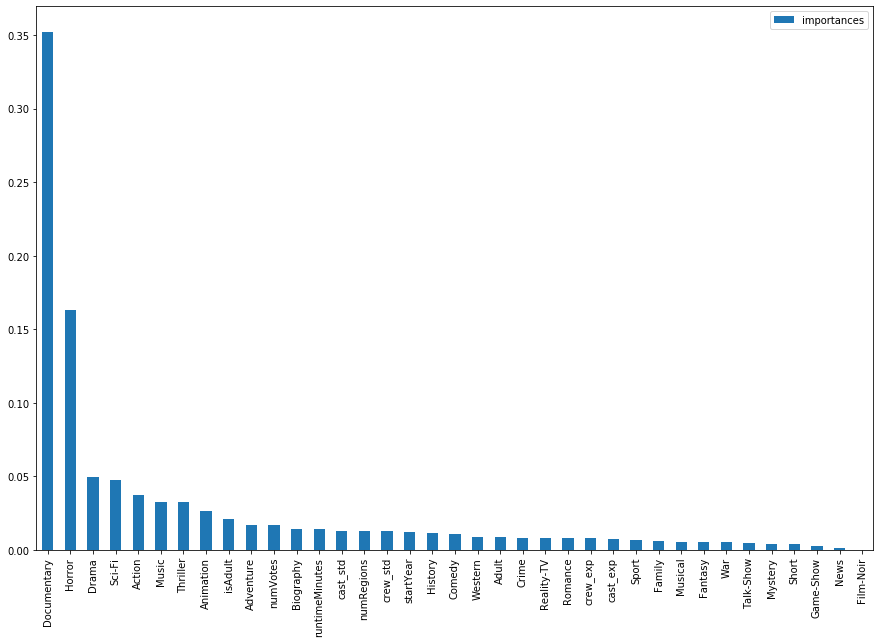

In [246]:
imp.plot.bar(figsize = (15, 10))

The model's performance is much worse with out these features. This indicates that greater enrichment of the dataset may be needed to predict a movies rating. Ideas for future features are presented in the documentation. 

## Model Analysis

In [42]:
print(X.shape, y.shape)

(323834, 41) (323834,)


In [43]:
xgb = XGBRegressor(subsample=0.8, n_jobs=-1, )

xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [46]:
xgb.score(X, y)

0.8493922616960377

In [47]:
preds = xgb.predict(X)

In [48]:
preds

array([4.396714 , 5.8287888, 4.938507 , ..., 9.281795 , 7.7796936,
       8.245296 ], dtype=float32)

In [58]:
df.describe()

,isAdult,runtimeMinutes,averageRating,numVotes,cast_mean,cast_std,cast_max,crew_mean,crew_std,crew_max,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,preds
count,323834.000000,323834.000000,323834.000000,3.238340e+05,323834.000000,323834.000000,323834.000000,323834.000000,323834.000000,323834.000000,...,323834.000000,323834.000000,323834.000000,323834.000000,323834.000000,323834.000000,323834.000000,323834.000000,323834.000000,323834.000000
mean,0.014285,91.235547,6.216690,2.985866e+03,6.179833,0.530523,7.389497,6.211778,0.494672,7.462756,...,0.000392,0.109927,0.023330,0.000077,0.012049,0.000068,0.080841,0.020594,0.016487,6.216690
std,0.118664,127.575322,1.353901,3.099838e+04,0.862707,0.531665,0.958137,0.865937,0.518935,0.869962,...,0.019800,0.312799,0.150949,0.008786,0.109107,0.008242,0.272591,0.142021,0.127338,1.236888
min,0.000000,0.000000,1.000000,5.000000e+00,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.561659
25%,0.000000,80.000000,5.400000,1.700000e+01,5.747144,0.000000,6.850000,5.746667,0.000000,7.050000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.511211
50%,0.000000,90.000000,6.300000,5.100000e+01,6.215477,0.654840,7.500000,6.240278,0.555642,7.555556,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.291383
75%,0.000000,100.000000,7.100000,2.540000e+02,6.609973,0.964899,8.020000,6.700000,0.927787,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.996336
max,1.000000,51420.000000,10.000000,2.551267e+06,10.000000,4.842949,10.000000,10.000000,5.091169,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.481356


In [59]:
genres = ['Action', 'Adult',
           'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
           'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History',
           'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
           'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War',
           'Western']

In [49]:
df = pd.read_csv('processed/title_rating_prof_reg_one.csv')

In [50]:
df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,genres,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,tt0000502,movie,Bohemios,Bohemios,0,1970-01-01 00:00:00.000001905,100.0,4.5,14,"Comedy,Musical",...,0,0,0,0,0,0,0,0,0,0
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1970-01-01 00:00:00.000001906,70.0,6.0,754,"Action,Adventure,Biography",...,0,0,0,0,0,0,0,0,0,0
2,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1970-01-01 00:00:00.000001907,90.0,4.6,17,Drama,...,0,0,0,0,0,0,0,0,0,0
3,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1970-01-01 00:00:00.000001907,96.0,4.5,23,Drama,...,0,0,0,0,0,0,0,0,0,0
4,tt0000630,movie,Hamlet,Amleto,0,1970-01-01 00:00:00.000001908,130.0,3.8,24,Drama,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323829,tt9916362,movie,Coven,Akelarre,0,2020-01-01,92.0,6.4,4447,"Drama,History",...,0,0,0,0,0,0,0,0,0,0
323830,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019-01-01,93.0,3.8,14,"Adventure,History,War",...,0,0,0,0,0,0,0,0,1,0
323831,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019-01-01,10.0,9.3,17,Comedy,...,0,0,0,0,0,0,0,0,0,0
323832,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019-01-01,123.0,8.3,6,Drama,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df['preds'] = preds

In [63]:
df[abs(df['preds'] - df['averageRating']) > 1]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,genres,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,preds
7,tt0000739,movie,El pastorcito de Torrente,El pastorcito de Torrente,0,1970-01-01 00:00:00.000001908,93.0,6.2,16,Drama,...,0,0,0,0,0,0,0,0,0,5.093509
15,tt0001038,movie,Sherlock Holmes VI,Sherlock Holmes VI,0,1970-01-01 00:00:00.000001910,113.0,3.8,21,"Drama,Comedy",...,0,0,0,0,0,0,0,0,0,6.011876
33,tt0001386,movie,Le roi des parfums,Le roi des parfums,0,1970-01-01 00:00:00.000001910,93.0,4.4,18,"Drama,History",...,0,0,0,0,0,0,0,0,0,6.785730
39,tt0001586,movie,A Dog's Tale,A Dog's Tale,0,1970-01-01 00:00:00.000001911,93.0,3.8,16,"Drama,War",...,0,0,0,0,0,0,0,1,0,6.451958
44,tt0001803,movie,The Mystery of a Hansom Cab,The Mystery of a Hansom Cab,0,1970-01-01 00:00:00.000001911,100.0,4.0,11,"Action,Adventure",...,0,0,0,0,0,0,0,0,0,5.213324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323735,tt9899368,movie,Lakewood Plaza Turbo,Lakewood Plaza Turbo,0,2013-05-21 00:00:00,9.0,4.8,8,"Action,Adventure,Animation",...,0,0,0,0,0,0,0,0,0,6.271432
323769,tt9905462,movie,Pengalila,Pengalila,0,2019-01-01,111.0,8.3,675,Drama,...,0,0,0,0,0,0,0,0,0,6.430416
323791,tt9910206,movie,Facebook idióták - A Mozifilm,Facebook idióták - A Mozifilm,0,2017-01-01,45.0,8.1,10,"Action,Adventure,Comedy",...,0,0,0,0,0,0,0,0,0,6.898620
323812,tt9914286,movie,Sokagin Çocuklari,Sokagin Çocuklari,0,2019-01-01,98.0,8.0,219,"Drama,Family",...,0,0,0,0,0,0,0,0,0,5.546380


In [57]:
df[abs(df['preds'] - df['averageRating']) > 2].describe()

,isAdult,runtimeMinutes,averageRating,numVotes,cast_mean,cast_std,cast_max,crew_mean,crew_std,crew_max,...,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,preds
count,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,1415.000000,...,1415.000000,1415.000000,1415.000000,1415.0,1415.000000,1415.0,1415.000000,1415.000000,1415.000000,1415.000000
mean,0.020495,87.615548,4.807350,1002.988693,5.976695,1.031321,7.752172,5.961060,0.945094,7.757892,...,0.001413,0.085512,0.017668,0.0,0.008481,0.0,0.038163,0.020495,0.010601,5.776906
std,0.141735,34.148263,2.061996,11619.842630,0.583623,0.560248,0.751228,0.628026,0.626272,0.711457,...,0.037582,0.279741,0.131788,0.0,0.091731,0.0,0.191656,0.141735,0.102449,1.015143
min,0.000000,0.000000,1.000000,5.000000,3.143902,0.000000,5.400000,3.280000,0.000000,5.666667,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,2.950122
25%,0.000000,73.000000,3.300000,10.000000,5.617462,0.962303,7.200000,5.600892,0.000000,7.286607,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,5.072733
50%,0.000000,93.000000,4.200000,19.000000,6.078570,1.169731,7.860000,6.060918,1.123133,7.807692,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,5.832543
75%,0.000000,99.000000,6.700000,59.000000,6.261143,1.383259,8.296667,6.291768,1.366402,8.250000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,6.456657
max,1.000000,485.000000,9.700000,311963.000000,8.236079,2.799298,9.800000,8.498294,2.756119,9.933333,...,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,9.152845


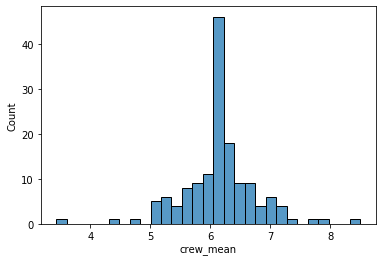

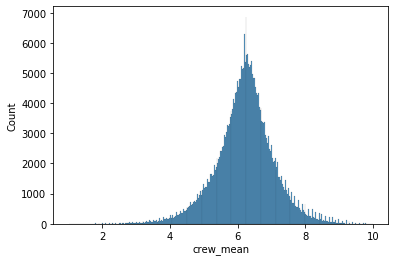

In [81]:
diff_3 = df[abs(df['preds'] - df['averageRating']) > 3]
sns.histplot(x = 'crew_mean', data = diff_3)
plt.show()
sns.histplot(x = 'crew_mean', data = df)

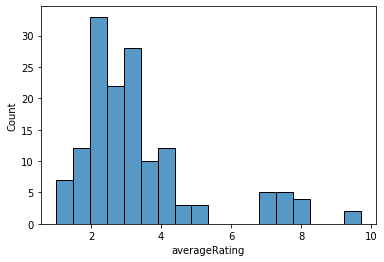

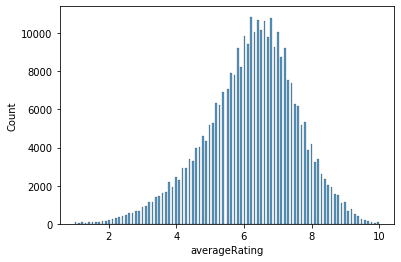

In [82]:
sns.histplot(x = 'averageRating', data = diff_3)
plt.show()
sns.histplot(x = 'averageRating', data = df)

We can see from the plots above that the biggest discrepancies in the predictions occur when a talented crew makes a bad film. Since the model relies heavily on crew performance, we can see that this mismatch is hard for the model to catch